In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import matplotlib.pyplot as plt
import gc
import numpy as np
import os
import sys
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS, ROUND_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.constants import (
    PROCESSED_DATA_PATH
)

In [4]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"

In [5]:
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [6]:
%load_ext autoreload
%autoreload

In [7]:
%%time
train = read_file(f"{RAW_TRAIN_PICKLE_PATH}/raw_train_data.pkl")
test = read_file(f"{RAW_TEST_PICKLE_PATH}/raw_test_data.pkl")

Shape of data: (5531451, 193)
Shape of data: (11363762, 192)
CPU times: user 5.11 s, sys: 6.86 s, total: 12 s
Wall time: 16.1 s


### D_45

In [86]:
test["D_45"].var() * (test["D_45"].shape[0] - 1) + (test["D_45"].sum() ** 2 / test["D_45"].shape[0])

1357867.2076751622

In [89]:
train["D_45"].var() * (train["D_45"].shape[0] - 1) + (train["D_45"].sum() ** 2 / train["D_45"].shape[0])

676057.9745209047

In [71]:
test["D_45"].describe()

count   11,360,784.0000
mean             0.2392
std              0.2437
min              0.0000
25%              0.0611
50%              0.1427
75%              0.3692
max              1.6504
Name: D_45, dtype: float64

In [67]:
pd.cut(test["D_45"].dropna(), 40000).unique()

[(0.0044562, 0.0044975], (0.0094901, 0.0095313], (0.0070144, 0.0070557], (0.0089124, 0.0089537], (0.0084998, 0.0085411], ..., (1.53186, 1.5319], (1.53388, 1.53393], (1.5404, 1.54044], (1.54989, 1.54993], (1.36348, 1.36352]]
Length: 36678
Categories (40000, interval[float64, right]): [(-0.0016504, 4.1269e-05] < (4.1269e-05, 8.253e-05] < (8.253e-05, 0.00012379] < (0.00012379, 0.00016505] ... (1.65028, 1.65032] < (1.65032, 1.65036] < (1.65036, 1.65041] < (1.65041, 1.65045]]

In [68]:
t = pd.cut(train["D_45"].dropna(), 40000)

In [69]:
t.cat.codes.nunique()

35591

In [50]:
len(t.sort_values().unique().tolist())

82974

In [44]:
pd.DataFrame(dict(
    train_bin=pd.cut(train["D_45"].dropna(), 100000).cat.codes,
    train_values

0          44031
1          44272
2          44775
3          44968
4          44758
           ...  
5531446    45886
5531447    46222
5531448    46398
5531449    46471
5531450    46632
Length: 5529434, dtype: int32

In [27]:
d = [np.percentile(train["D_45"], i*0.01) for i in range(10000)]


KeyboardInterrupt



In [93]:
train["temp"] = (train["D_45"] - train["D_45"].min()) / (train["D_45"].max() - train["D_45"].min())

In [92]:
test["temp"] = (test["D_45"] - test["D_45"].min()) / (test["D_45"].max() - test["D_45"].min())

In [117]:
train["temp"] = train["D_45"].copy()
test["temp"] = test["D_45"].copy()

In [118]:
train["temp"].describe()

count   5,529,434.0000
mean            0.2508
std             0.2422
min             0.0000
25%             0.0546
50%             0.1808
75%             0.3733
max             1.6100
Name: temp, dtype: float64

In [120]:
test["temp"]

0          0.0045
1          0.0095
2          0.0070
3          0.0089
4          0.0085
            ...  
11363757   0.0113
11363758   0.0184
11363759   0.0136
11363760   0.0162
11363761   0.0189
Name: temp, Length: 11363762, dtype: float32

In [115]:
test["temp"] + (train["temp"].mean() - test["temp"].mean()) / (abs(train["temp"].std() - test["temp"].std()) * 500)

0          0.0084
1          0.0135
2          0.0110
3          0.0129
4          0.0125
            ...  
11363757   0.0153
11363758   0.0224
11363759   0.0176
11363760   0.0202
11363761   0.0228
Name: temp, Length: 11363762, dtype: float64

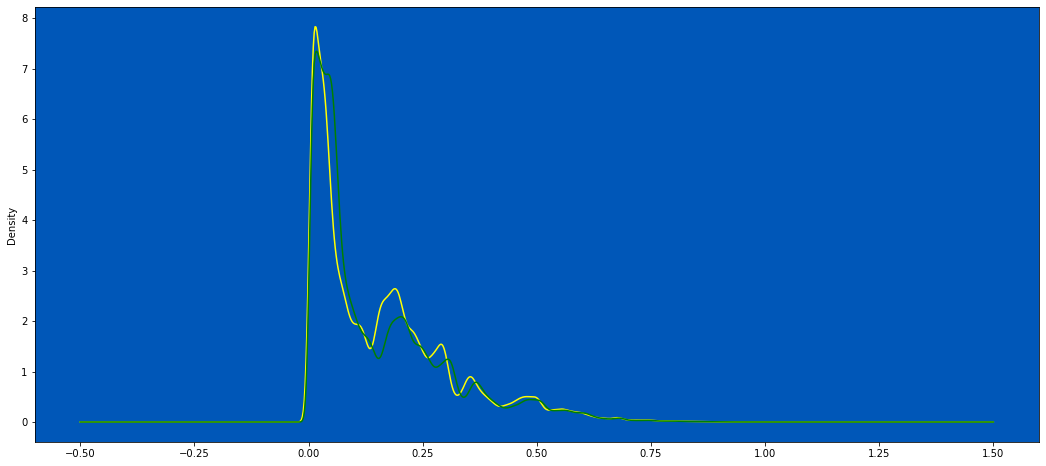

In [94]:
plot_train_test_distribution(train, test, col="temp")

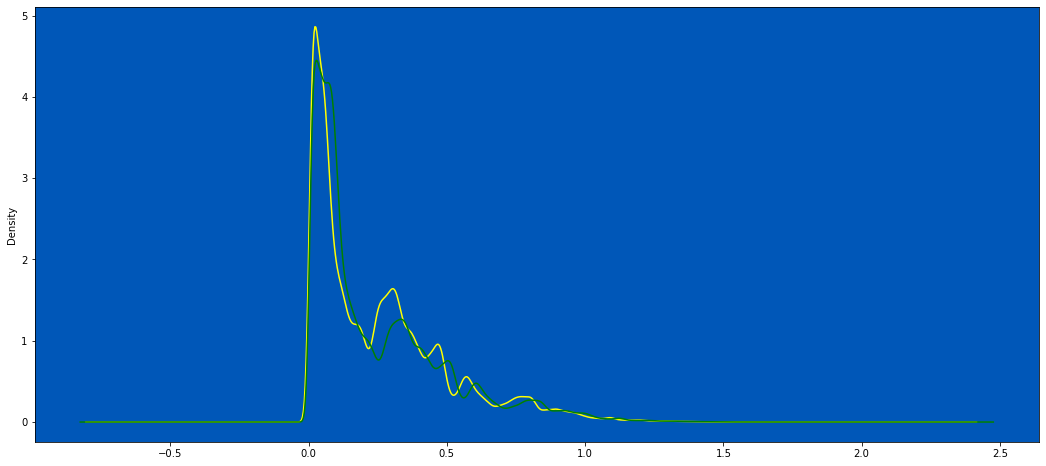

In [23]:
plot_train_test_distribution(train, test, col="D_45")

In [261]:
index = 1
col = float_cols[index]

count   5,531,451.000
mean            0.229
std             4.797
min            -0.003
25%             0.029
50%             0.111
75%             0.296
max         4,097.441
Name: B_10, dtype: float64


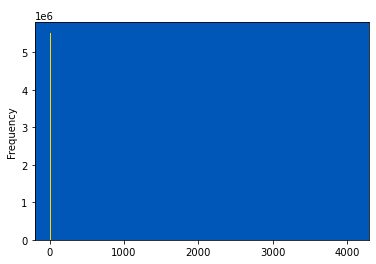

count   11,363,762.000
mean             0.239
std              5.538
min             -0.003
25%              0.029
50%              0.115
75%              0.296
max          4,660.357
Name: B_10, dtype: float64


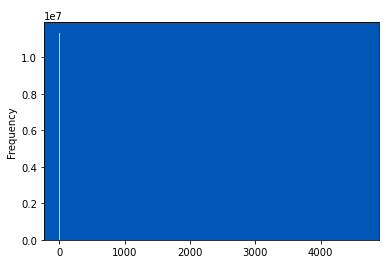

In [262]:
compare_train_test_distribution(train, test, col)

In [263]:
print(f"Train missing proportion {train[col].isnull().sum() / train.shape[0]:.2%}")
print(f"Test missing proportion {test[col].isnull().sum() / test.shape[0]:.2%}")

Train missing proportion 0.00%
Test missing proportion 0.00%


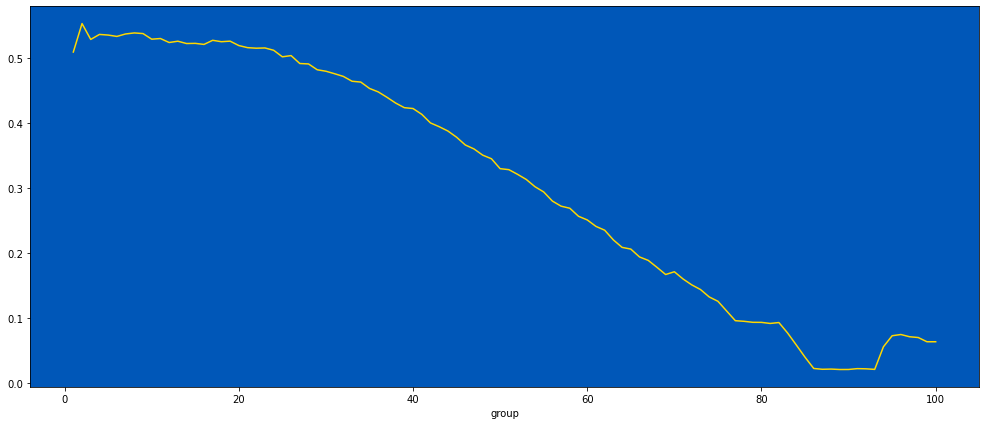

In [264]:
plt.figure(figsize=(17, 7))
train["group"] = pd.qcut(train[col].drop_duplicates(), q=100).cat.codes + 1
train.groupby(["group"])["target"].mean().plot() # "row_number", 
plt.show()

In [271]:
np.percentile(train[col].dropna(), 99.6)

2.4658042907714854

In [248]:
t1 = train.loc[train[col].between(3.2, 50)]
t1["target"].mean(), t1.shape[0]

(0.2264020309254558, 4333)

In [249]:
t2 = train.loc[train[col].between(1, 2)]
t2["target"].mean(), t2.shape[0]

(0.33489607751211126, 44793)

In [114]:
t2 = train.loc[train[col].between(0.06, 0.07)]
t2["target"].mean(), t2.shape[0]

(0.26009246653816603, 148378)

In [76]:
train.loc[train[col].isnull()]["target"].mean()

0.3005334772572064

In [241]:
train.loc[train[col].between(0.2, 0.3)]["target"].mean()

0.08370293532198828

In [219]:
train.loc[train[col] == 0]["target"].mean()

0.2085656683224908

In [220]:
train.loc[train[col] > 0]["target"].mean()

0.5203464529649717

In [171]:
train.loc[train[col].between(-1, 0.25)]["target"].mean()

0.18761871376099448

In [158]:
train["target"].mean()

0.24909720794778803

In [56]:
# test[col].isnull().sum()

In [57]:
# train.loc[train[col] > 0.0][col]  # .between(0.01, 0.99)

In [58]:
# np.percentile(test[col], 99)

In [59]:
# train.loc[train[col].between(0.001, 0.1)]["target"].mean()

In [60]:
# train.loc[train[col] > 0][["customer_ID", "D_41", "target"]].tail(50)

In [24]:
float_cols = train.select_dtypes(np.float).columns.tolist()
float_cols = sorted(float_cols)

### B_1

In [125]:
column = "B_1"

In [126]:
b1_min_outlier_thr = -0.05

In [128]:
train.loc[train[column] < b1_min_outlier_thr, column] = b1_min_outlier_thr
test.loc[test[column] < b1_min_outlier_thr, column] = b1_min_outlier_thr

### B_9

In [ ]:
column = "B_9"

In [ ]:
%%time
train.loc[train[column] > 1, column] = 1
test.loc[test[column] > 1, column] = 1

CPU times: user 32 ms, sys: 4.06 ms, total: 36 ms
Wall time: 16.3 ms


### B_14

In [220]:
column = "B_14"

In [221]:
%%time
train.loc[train[column] < 0, column] = 0
test.loc[test[column] < 0, column] = 0

CPU times: user 37.8 ms, sys: 9.93 ms, total: 47.8 ms
Wall time: 28.5 ms


In [250]:
%%time
value = 3
train.loc[train[column] > value, column] = value
test.loc[test[column] > value, column] = value

CPU times: user 35.4 ms, sys: 5.98 ms, total: 41.4 ms
Wall time: 19.9 ms


### B_27

In [32]:
column = "B_27"

In [33]:
%%time
train = train.drop(columns=column, errors="ignore")
test = test.drop(columns=column, errors="ignore")

CPU times: user 829 ms, sys: 3.03 s, total: 3.86 s
Wall time: 6.3 s


In [34]:
gc.collect()

10620